# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Нам предстоит провести исследование данных, проверить на наличие аномалий и избавиться от них. Далее, нам необходимо протестировать несколько моделей, одной из которой будет LightGBM, и как минимум одна- не бустинг. Надо будет сравнить результаты, время обучения и скорость предсказания и выбрать оптимальную.

Наш работа пройдет в 7 этапов:
- Загрузка данных
- Изучение данных
- Подготовка выборок
- Обучение разных моделей
- Анализ времени обучения, времени предсказания и качества моделей.
- Выбор лучшей модели
- Подведение итогов

Приступим к работе

 ## Произведем необходимые импорты

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from tqdm import tqdm

import lightgbm as lgb

from catboost import CatBoostRegressor, cv, Pool


import category_encoders as ce


Расширим размеры ноутбука

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\495279268.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Подготовка данных

### Загрузим данные

In [4]:
df = pd.read_csv('autos.csv')
df.head()

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0   golf     150000                  0    petrol  volkswagen      NaN   
1    NaN     125000                  5  gasoline        audi      yes   
2  grand     125000                  8  gasoline        jeep      NaN   
3   golf     150000                  6    petrol  volkswagen       no   
4  fabia      90000                  7  gasoline       skoda       no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00:00:00                 0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                 0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                 0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00                 0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00                 0       60437  2016-04-06 10:17:21

Документация датасета

**Признаки**

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType`— тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**

Price — цена (евро)

**Не информативными являются признаки:**
- `LastSeen` - дата последней активности пользователя
- `DateCreated` — дата создания анкеты
- `DateCrawled` — дата скачивания анкеты из базы


**Остается под вопросом:**
- `PostalCode` - почтовый индекс владельца анкеты (пользователя), так как возможно можно будет отследить изменение цены по регионам.
- `NumberOfPictures` - количество фотографий автомобиля, инетересно понаблюдать как это вообще влияет. Возмодно владельцы, которым  нечего скрывать, выкладывают больше фотографий.

### Изучим данные

Выведем общую  информацию о датасете

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.describe()

Price  RegistrationYear          Power      Kilometer  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.000000  
50%             6.000000               0.0   49413.000000  
75%             9.000000               0.0   71083.000000  
max            12.000000               0.0   99998.000000

**признак NumberOfPictures не имеет каких-либо значений отличных от 0, значит, он не несет никакого практического смысла для нас, можем его удалить**

В данных присутствую пропуски, в признаках отвечающих за дату нужно изменить тип данных на дату. Посмотрим на типы данных повнимательнее

In [7]:
df.dtypes

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
Repaired             object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object

Скопируем изначальный датасет в запасную переменную

In [8]:
df_init = df.copy()

In [9]:
df_1 = df.copy()

In [10]:
%%time

df_1=df_1.drop('LastSeen', axis=1)

CPU times: total: 31.2 ms
Wall time: 28.8 ms


In [11]:
%%time

del df['LastSeen']


CPU times: total: 0 ns
Wall time: 0 ns


будем использовать конструкцию drop, так как она привычнее и можно удалить сразу несколько столбцов

In [12]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode'],
      dtype='object')

In [13]:
df = df.drop(['DateCrawled', 'DateCreated','NumberOfPictures'],axis=1)

In [14]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired',
       'PostalCode'],
      dtype='object')

Выделим int и object признаки

In [15]:
df.dtypes

Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
Repaired             object
PostalCode            int64
dtype: object

In [16]:
numeric_feats = ['Price', 'RegistrationYear','Power','Kilometer','RegistrationMonth','PostalCode']
obj_feats = ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']

#### Разберемся с пропусками

In [17]:
df.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
PostalCode               0
dtype: int64

In [18]:
display(df['VehicleType'].unique())
df['VehicleType'].value_counts()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [19]:
df.groupby(by=['Brand','PostalCode']).mean()

C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\3510526402.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(by=['Brand','PostalCode']).mean()


Price  RegistrationYear  Power  Kilometer  \
Brand      PostalCode                                               
alfa_romeo 1067        4800.0            2008.0  120.0    80000.0   
           1109        1500.0            2002.0  120.0   150000.0   
           1239        1000.0            2001.0  120.0   150000.0   
           1309        5400.0            2009.0  155.0   125000.0   
           1558         799.0            2005.0  146.0   150000.0   
...                       ...               ...    ...        ...   
volvo      99846        400.0            1998.0  115.0   150000.0   
           99848        800.0            1995.0   90.0   100000.0   
           99867       8900.0            2007.0  179.0   125000.0   
           99947       1860.0            1999.0  105.0   150000.0   
           99974       2500.0            1999.0  140.0   150000.0   

                       RegistrationMonth  
Brand      PostalCode                     
alfa_romeo 1067                     12.0  
           1109                      9.0  
           1239                      2.0  
           1309                      3.0  
           1558                      2.0  
...                                  ...  
volvo      99846                     5.0  
           99848                     9.0  
           99867                     6.0  
           99947                     9.0  
           99974                    12.0  

[92613 rows x 5 columns]

**избавимся от пропусков**


In [20]:
df_test = df.copy()

Посмотрим какой у нас баланс в каждом признаке

In [21]:
filled_objects = ['VehicleType','Gearbox','Model','FuelType','Repaired'] # объекты которые подлежат заполнению

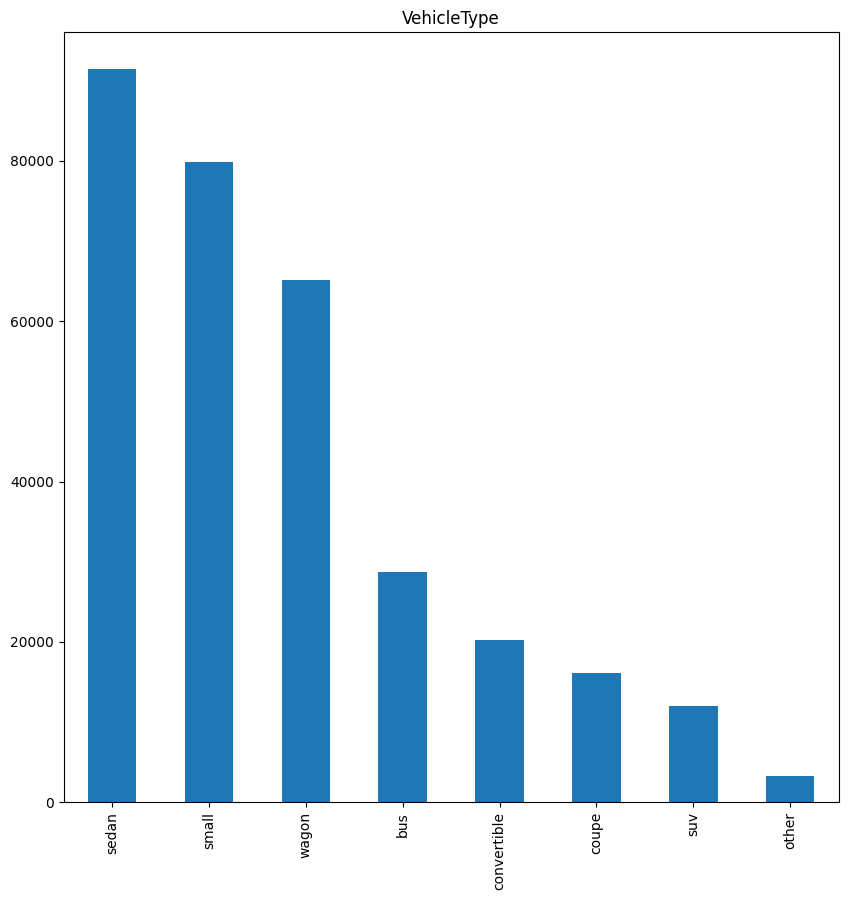

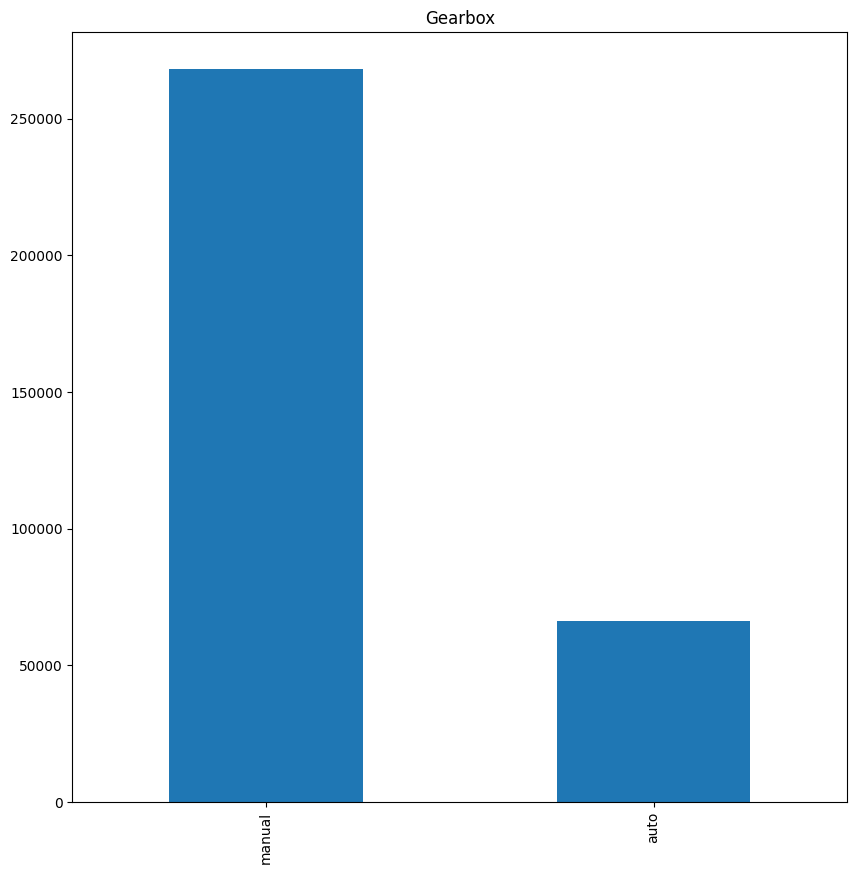

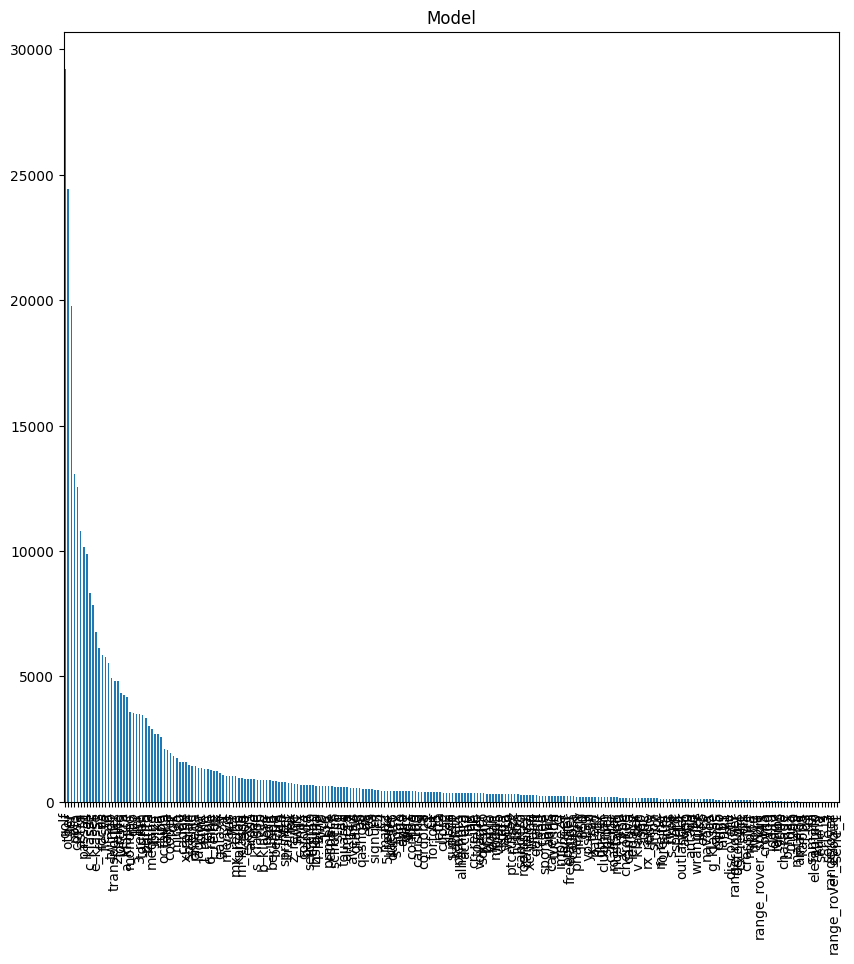

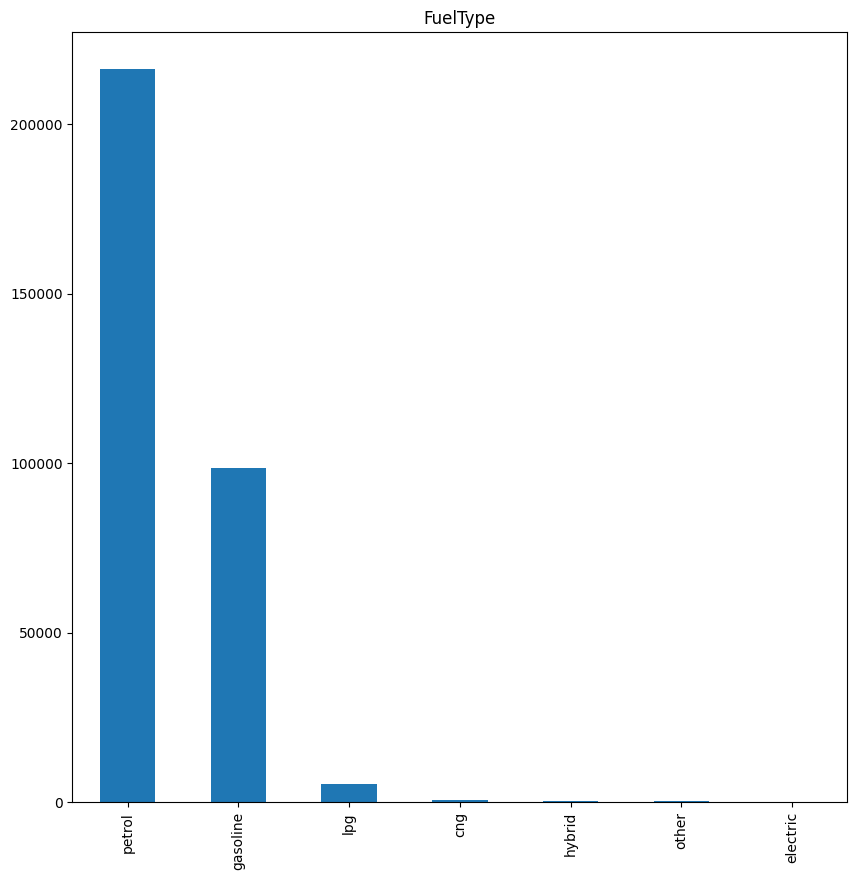

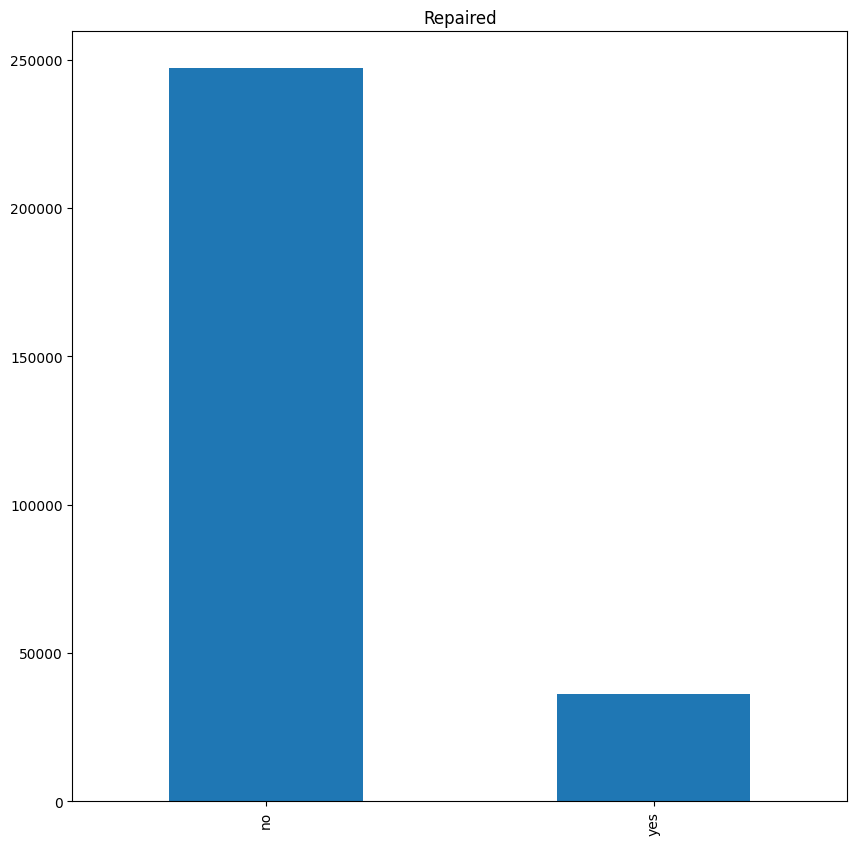

In [22]:
for feat in filled_objects:
    df[feat].value_counts().plot(kind='bar',figsize=(10,10), title=feat);
    plt.show()
# df_test[['VehicleType','Gearbox','Model','FuelType','Repaired']].value_counts().plot(kind='bar',figsize=(10,10));

In [23]:
df[['VehicleType','Gearbox','Model','FuelType','Repaired']] = (df
         .groupby(['Brand'])[['VehicleType','Gearbox','Model','FuelType','Repaired']]  # группируем авто по маркам
         .apply(lambda x: x.sort_values(by='VehicleType').fillna(method="bfill").fillna(method="ffill"))  # производим замены внутри групп марок
         .droplevel(0)   # избавляемся от мультииндекса
         .sort_index(ascending=True))[['VehicleType','Gearbox','Model','FuelType','Repaired']] # сортируем строки по индексу

In [24]:
df.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox                 0
Power                   0
Model                3374
Kilometer               0
RegistrationMonth       0
FuelType                0
Brand                   0
Repaired                0
PostalCode              0
dtype: int64

In [25]:
df = df.dropna(subset=['Model'])
df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
PostalCode           0
dtype: int64

<Figure size 1000x1000 with 0 Axes>

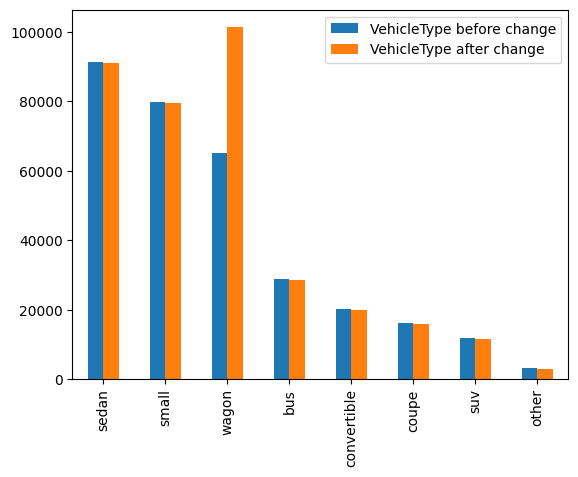

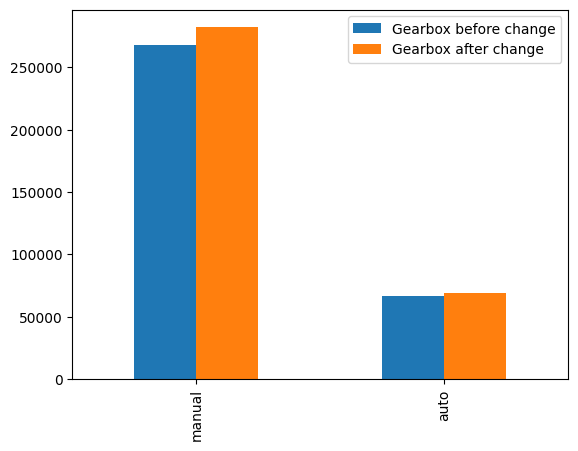

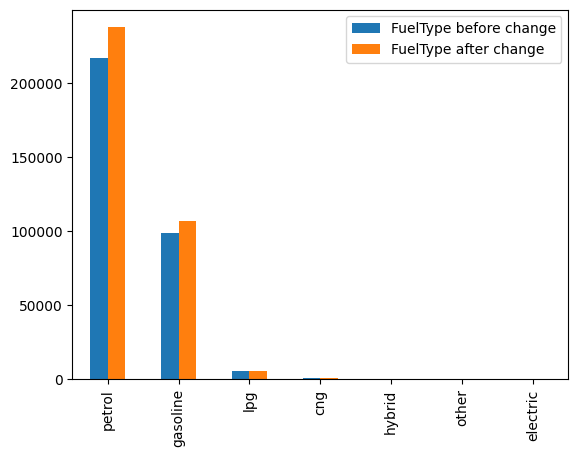

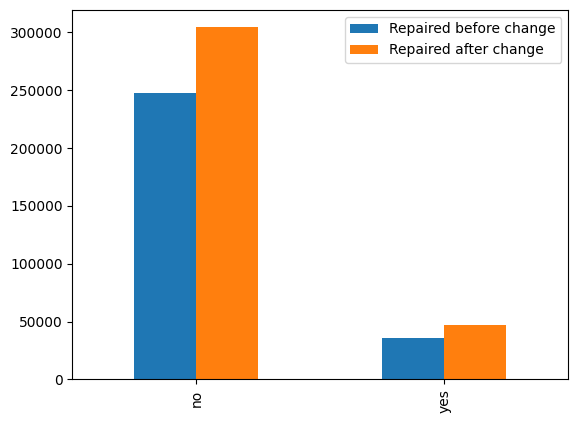

CPU times: total: 656 ms
Wall time: 639 ms


In [26]:
%%time
filled_objects = ['VehicleType','Gearbox','FuelType','Repaired'] # объекты которые подлежат заполнению

plt.figure(figsize=(10,10))
for feat in filled_objects:
    df_dinamic = pd.concat([df_test[feat].value_counts(),df[feat].value_counts()],names=['1','2'],axis=1)
    df_dinamic.columns=[str(feat)+' before change', str(feat)+' after change']
    df_dinamic.plot(kind='bar', );
    plt.show();

отлично, заменили пропуски, примерно сохранив баланс классов.

#### Проверим датасет на аномалии

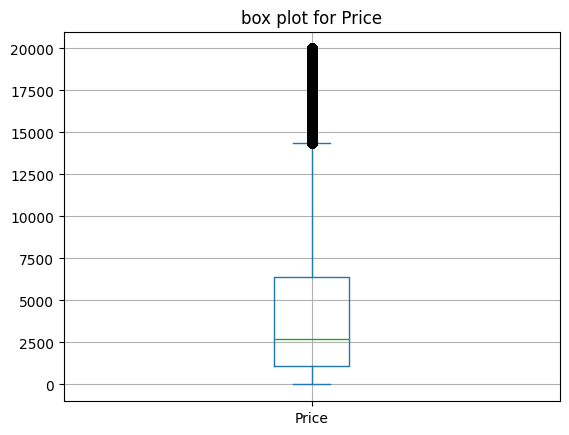

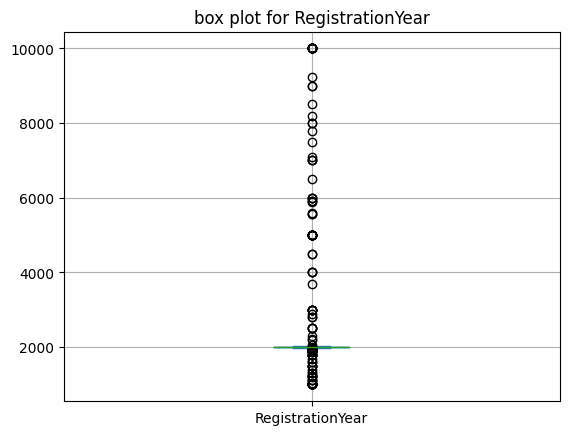

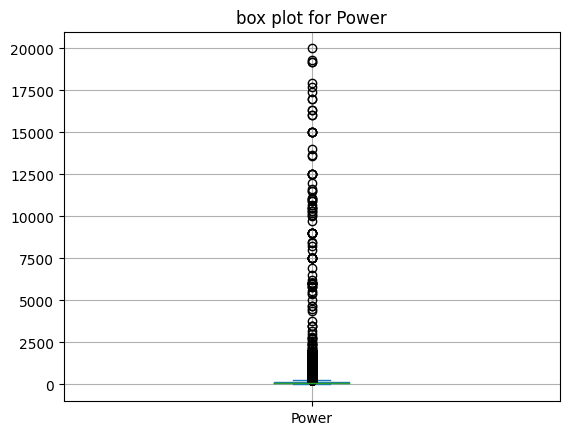

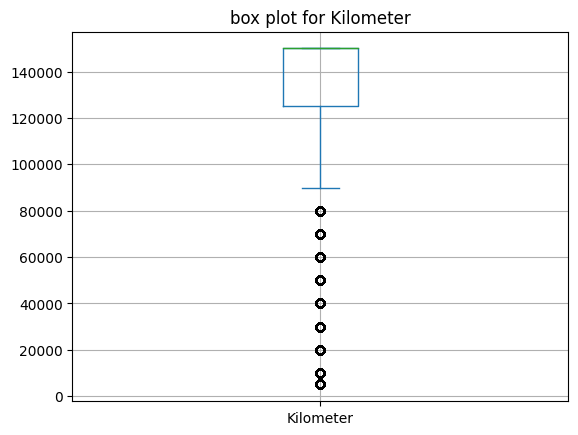

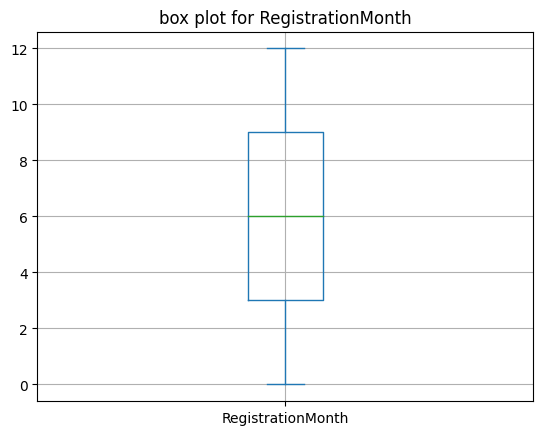

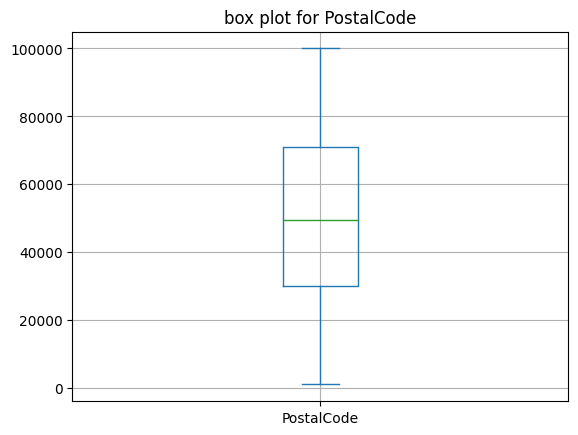

In [27]:
for feat in numeric_feats: 
    df[feat].plot(kind='box',grid=True, title='box plot for '+str(feat))
    plt.show()

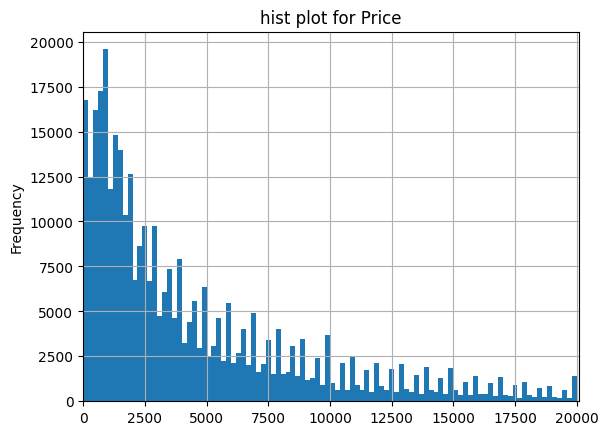

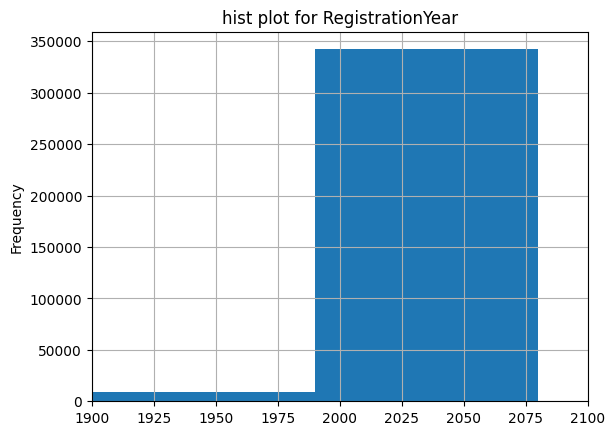

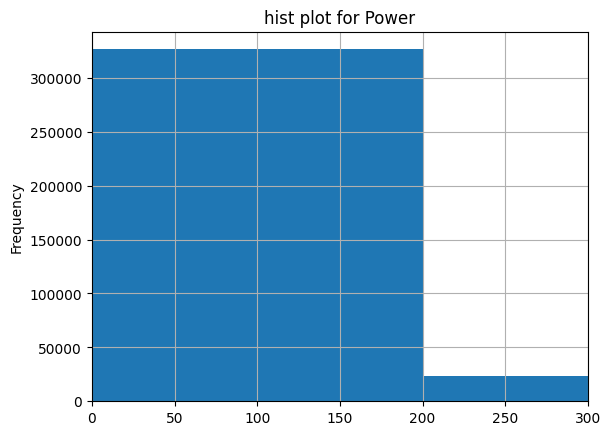

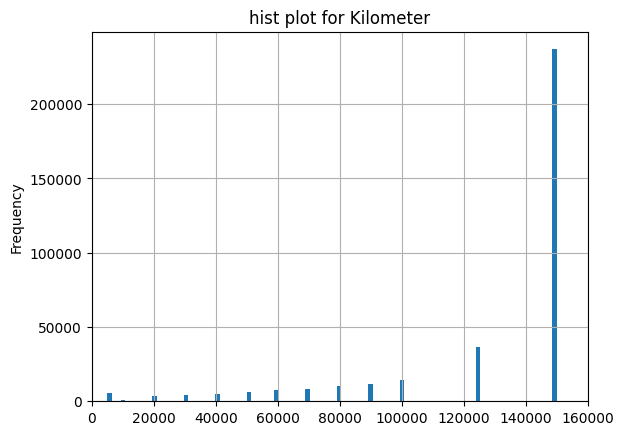

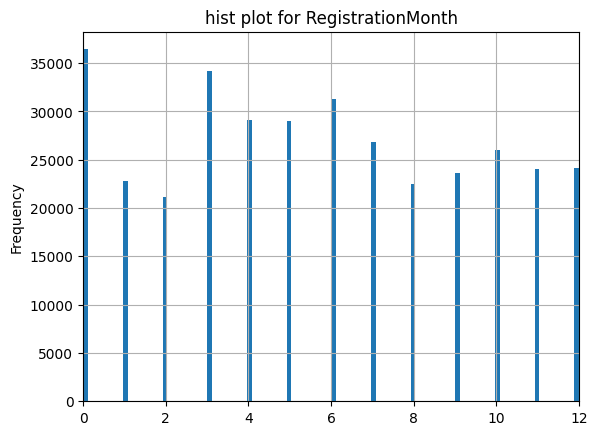

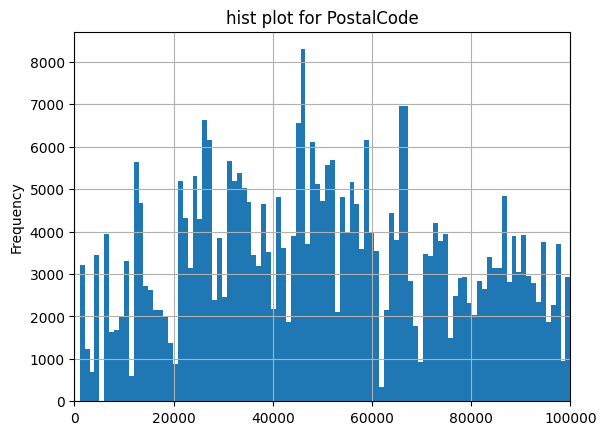

In [28]:
xl = [(0,20100), (1900,2100),(0,300),(0, 160000), (0,12),(0,100001)]
i = 0
for feat in numeric_feats: 
    df[feat].plot(kind='hist',grid=True, title='hist plot for '+str(feat), bins=100,xlim=xl[i])
    plt.show()
    i+=1
    

#### Исправляем аномалии

**Цена**

Цены оставим почти без изменений, но нужно только избавиться от совсем маленьких стоимостей.


In [29]:
df.loc[(df['Price']<100)&(df['Price']>=0)].shape

(12640, 12)

Избавимся от этих данных, потому что их не так много ,чтобы это как-то серьезно сказалось на обучении.

In [30]:
df = df.loc[df['Price']>100]
df.shape

(337341, 12)

**Год регистрации**

Проанализировав сайт auto.ru стало заметно, что до 1960 года, можно найти только очень редкие автомобили, и их всего 120 штук, поэтому посмотрим сколько всего позиций выходит за пределы наших рамок

In [31]:
df.loc[(df['RegistrationYear']<=1960)|(df['RegistrationYear']>=2023)].shape

(346, 12)

In [32]:
df.shape

(337341, 12)

Уверен, что мы смело можем отбросим эти неммногочисленные аномалии

In [33]:
df = df.loc[(df['RegistrationYear']>1960)&(df['RegistrationYear']<=2023)]
df.shape

(336995, 12)

In [34]:
df_init.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [35]:
df_init.loc[(df_init['RegistrationYear']<1960)|(df_init['RegistrationYear']>2023),['DateCrawled','RegistrationYear']].head(20)

DateCrawled  RegistrationYear
15     2016-03-11 21:39:15              1910
622    2016-03-16 16:55:09              1111
1928   2016-03-25 15:58:21              1945
2273   2016-03-15 21:44:32              1925
3333   2016-03-15 21:36:20              1955
6629   2016-04-02 13:47:16              1910
6977   2016-03-24 08:37:22              1910
10183  2016-03-27 13:59:08              1910
12946  2016-03-29 18:39:40              5000
12992  2016-04-03 19:38:21              1954
12993  2016-03-07 14:38:00              1955
13177  2016-03-19 13:45:25              1958
14971  2016-03-30 11:57:50              1959
15147  2016-03-14 00:52:02              9999
15414  2016-03-30 23:38:13              1956
15870  2016-04-02 11:55:48              3200
16062  2016-03-29 23:42:16              1000
16635  2016-03-09 10:54:11              1941
17271  2016-03-23 16:43:29              9999
17346  2016-03-06 16:06:20              8888

**Количество сил**

Проанализировав сайт auto.ru, могу сказать, что зачастую автомобили имеют количество сил менее 350, но бывают исключения, бы на них постараемся закрыть глаза, потом учто это уже очень редко попадающиеся автомобили.

Проверим сколько таких автомобилей есть в наших данных.

In [36]:
df.loc[df['Power']>350].shape

(1086, 12)

Очень маленькое количество вылезает за эти пределы, поэтому безболезненно отбросим эти строки

<Axes: >

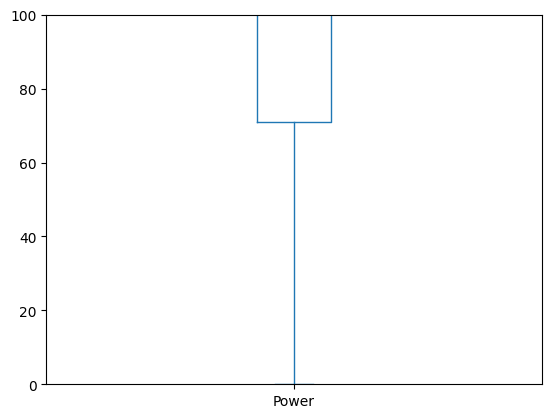

In [37]:
df['Power'].plot(kind='box', ylim=(0,100))

In [38]:
df.loc[df['Power']<1].shape

(33680, 12)

In [39]:
df.loc[df['Power']<50].shape

(38843, 12)

Реалистичная мощность автомобилей находится в пределах 50-350 л.с.

In [40]:
df = df.loc[(df['Power']<=350)&(df['Power']>=50)]
df.shape

(297066, 12)

**Пробег**

Пробег трогать не будет, потому что значения лежат в пределах нормы, поэтому оставим все как есть

**Месяц регистрации**

Месяц регистрации, на столбчатом графике видим, что значения месяца регистрации имеют значения от 0 до 12, очевидно, что нет 0го месяца. Поэтому заменим его на рандомное значение в пределах от 1 до 12 включительно. Потому что не совсем понятно как именно влияет месяц регистрации на стоимость. Но я слышал убеждение, что есть действительно такая закономерность, постараемся ее тоже проверить.

In [41]:
state = np.random.RandomState(12345)

In [42]:
df.loc[df['RegistrationMonth']==0, 'RegistrationMonth'] = np.random.randint(1,12)


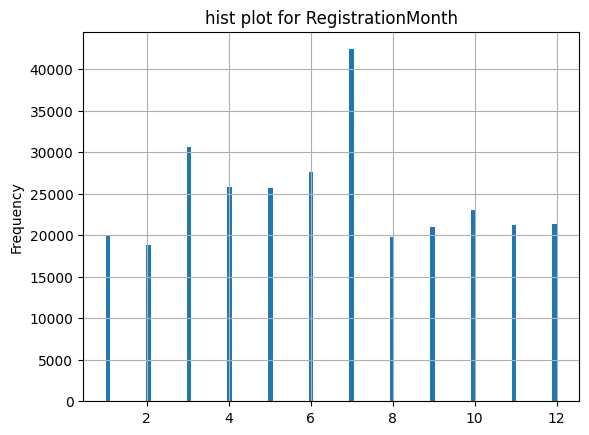

In [43]:
df['RegistrationMonth'].plot(kind='hist',grid=True, title='hist plot for RegistrationMonth', bins=100)
plt.show()

**Почтовый индекс**

С почтовым индексом все впорядке

### Проверим на явные дубликаты

In [44]:
df.duplicated().sum()

21074

In [45]:
df = df.drop_duplicates()

In [46]:
df.duplicated().sum()

0

In [47]:
df.shape

(275992, 12)

### Попробуем найти неявные дубликаты

In [48]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired',
       'PostalCode'],
      dtype='object')

In [49]:
df['VehicleType'].unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'other'], dtype=object)

In [50]:
df['Gearbox'].unique()

array(['manual', 'auto'], dtype=object)

In [51]:
df['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [52]:
df['Brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo'],
      dtype=object)

Неявных дубликатов обнаружено не было!

### Итоги подготовки данных

Провели все необходимые проверки данных.

Посмотрели на количество пропусков. Устранили пропуски за счет замены их на значения, которые получили при разделение на группы по брендам, так как в брендах нет пропусков, не появилось никаких аномалий.

Проверили данные на аномалии, избавились от выбросов, удалив данные, так как их количество было мало.

Проверили на явные и неявные дубликаты, удалили явные дубликаты, неявных дубликатов в данных нет.

In [53]:
!pip3 install pandas_profiling[notebook]

  Obtaining dependency information for ipywidgets>=7.5.1 from https://files.pythonhosted.org/packages/4a/0e/57ed498fafbc60419a9332d872e929879ceba2d73cb11d284d7112472b3e/ipywidgets-8.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for comm>=0.1.3 from https://files.pythonhosted.org/packages/fe/47/0133ac1b7dc476ed77710715e98077119b3d9bae56b13f6f9055e7da1c53/comm-0.1.4-py3-none-any.whl.metadata
  Obtaining dependency information for widgetsnbextension~=4.0.9 from https://files.pythonhosted.org/packages/29/03/107d96077c4befed191f7ad1a12c7b52a8f9d2778a5836d59f9855c105f6/widgetsnbextension-4.0.9-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab-widgets~=3.0.9 from https://files.pythonhosted.org/packages/e8/05/0ebab152288693b5ec7b339aab857362947031143b282853b4c2dd4b5b40/jupyterlab_widgets-3.0.9-py3-none-any.whl.metadata
Using cached ipywidgets-8.1.1-py3-none-any.whl (139 kB)
Using cached comm-0.1.4-py3-none-any.whl (6.6 kB)
Using cached jupyterlab_wi


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [54]:
from pandas_profiling import ProfileReport


profile = ProfileReport(df, title="Pandas Profiling Report")

# запускаем показ профиля
profile

C:\Users\vlad2\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\vlad2\AppData\Local\Programs\Python\Python310\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\1266673823.py:1: DeprecationWarning: `i

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Обучение моделей

Наша задача заключается в тестировании нескольких моделей.Этими моделями будут:
- [x] LinearRegression
- [x] RandomForestRegressor
- [x] LightGBM
- [x] CatBoost




### Разделим данные на выборки

Приходится делить выборки в отношении 6:4, потому что иначе при большей обучающей выборке умирает ядро):

In [55]:
features = df.drop('Price', axis=1)
target = df['Price']

features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=12345)



print('Соотношение выборок: обучающая', features_train.shape[0],': валидационная',features_valid.shape[0],': тестовая',features_test.shape[0])

Соотношение выборок: обучающая 165595 : валидационная 55198 : тестовая 55199


In [ ]:
#### Проведем прямое кодирование, бинарное кодирование для категориальных признаков.

In [56]:
features_train.dtypes

VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
Repaired             object
PostalCode            int64
dtype: object

In [57]:
# encoder_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# obj_feats = features_train.select_dtypes(include='object').columns.to_list()

# encoder_ohe.fit(features_train[obj_feats])

# # print(encoder_ohe.get_feature_names())
# # features_train[] = encoder_ohe.transform(features_train[obj_feats])



C:\Users\vlad2\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False)

In [74]:
features_train_ohed = features_train.copy()

features_train_ohed[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train_ohed[obj_feats])

features_train_ohed = features_train_ohed.drop(obj_feats, axis=1)

C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\4186925782.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_train_ohed[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train_ohed[obj_feats])
C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\4186925782.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_train_ohed[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train_ohed[obj_feats])
C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\4186925782.py:3: PerformanceWarn

C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\4186925782.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_train_ohed[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train_ohed[obj_feats])
C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\4186925782.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_train_ohed[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train_ohed[obj_feats])
C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\4186925782.py:3: PerformanceWarn

C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\4186925782.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_train_ohed[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train_ohed[obj_feats])
C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\4186925782.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_train_ohed[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train_ohed[obj_feats])
C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\4186925782.py:3: PerformanceWarn

In [76]:
features_test_ohed = features_test.copy()
features_test_ohed[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test_ohed[obj_feats])

features_test_ohed = features_test_ohed.drop(obj_feats, axis=1)

C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\2106360923.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_test_ohed[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test_ohed[obj_feats])
C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\2106360923.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_test_ohed[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test_ohed[obj_feats])
C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\2106360923.py:2: PerformanceWarning:

In [78]:
features_valid_ohed = features_valid.copy()
features_valid_ohed[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_valid_ohed[obj_feats])

features_valid_ohed = features_valid_ohed.drop(obj_feats, axis=1)

C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\86461604.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_valid_ohed[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_valid_ohed[obj_feats])
C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\86461604.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_valid_ohed[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_valid_ohed[obj_feats])
C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\86461604.py:2: PerformanceWarning: D

C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\86461604.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_valid_ohed[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_valid_ohed[obj_feats])
C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\86461604.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_valid_ohed[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_valid_ohed[obj_feats])
C:\Users\vlad2\AppData\Local\Temp\ipykernel_13216\86461604.py:2: PerformanceWarning: D

Провели прямое кодирование(One Hot Encoding) теперь приступим к обучению

In [79]:
features_train_encoded = ce.BinaryEncoder().fit_transform(features_train)
features_train_encoded.head()

VehicleType_0  VehicleType_1  VehicleType_2  VehicleType_3  \
212606              0              0              0              1   
316399              0              0              1              0   
82362               0              0              1              1   
223808              0              0              1              0   
45399               0              0              1              1   

        RegistrationYear  Gearbox_0  Gearbox_1  Power  Model_0  Model_1  ...  \
212606              2001          0          1    170        0        0  ...   
316399              2012          1          0     75        0        0  ...   
82362               2005          1          0     55        0        0  ...   
223808              1999          0          1    125        0        0  ...   
45399               2012          1          0    105        0        0  ...   

        FuelType_2  Brand_0  Brand_1  Brand_2  Brand_3  Brand_4  Brand_5  \
212606           1        0        0        0        0        0        1   
316399           1        0        0        0        0        1        0   
82362            1        0        0        0        0        0        1   
223808           1        0        0        0        0        1        1   
45399            0        0        0        0        0        0        1   

        Repaired_0  Repaired_1  PostalCode  
212606           0           1       63584  
316399           0           1       87463  
82362            0           1       50389  
223808           0           1       10999  
45399            0           1        7745  

[5 rows x 30 columns]

In [80]:
binenc = ce.BinaryEncoder().fit(features_train)
features_test_encoded = binenc.transform(features_test)

In [81]:
features_valid_encoded = binenc.transform(features_valid)

In [82]:
features_test_encoded.head()

VehicleType_0  VehicleType_1  VehicleType_2  VehicleType_3  \
273461              0              0              1              0   
160209              0              0              1              0   
247793              0              0              0              1   
289061              0              0              1              0   
192963              0              1              0              1   

        RegistrationYear  Gearbox_0  Gearbox_1  Power  Model_0  Model_1  ...  \
273461              2009          1          0    143        0        0  ...   
160209              1995          1          0    125        0        0  ...   
247793              2007          1          0    122        0        0  ...   
289061              1997          1          0     55        0        0  ...   
192963              2010          1          0    170        0        1  ...   

        FuelType_2  Brand_0  Brand_1  Brand_2  Brand_3  Brand_4  Brand_5  \
273461           0        0        0        0        0        1        1   
160209           1        0        0        0        0        1        1   
247793           0        0        0        0        1        0        1   
289061           1        0        1        0        0        1        0   
192963           0        0        0        0        0        1        1   

        Repaired_0  Repaired_1  PostalCode  
273461           0           1       49477  
160209           1           0       84061  
247793           0           1       66892  
289061           0           1       90762  
192963           0           1       48683  

[5 rows x 30 columns]

### Линейная регрессия

In [83]:
numeric = numeric_feats[1:]
numeric

['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode']

#### Масштабируем данные для линейной регрессии

In [84]:
scaler = StandardScaler()

scaler.fit(features_train[numeric])

features_train_scaled, features_test_scaled = features_train.copy(), features_test.copy()


features_train_scaled_ohed = features_train_ohed.copy()
# features_valid_scaled_ohed = features_valid_ohed.copy()
features_test_scaled_ohed = features_test_ohed.copy()

features_train_scaled_ohed[numeric] = scaler.transform(features_train[numeric])
# features_valid_scaled_ohed[numeric] = scaler.transform(features_valid[numeric])
features_test_scaled_ohed[numeric]  = scaler.transform(features_test[numeric])

# scaler= StandardScaler()
# features_valid[numeric] = scaler.transform(features_valid[numeric])

In [85]:
features_train_scaled_ohed.columns

Index(['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth',
       'PostalCode', 'VehicleType_bus', 'VehicleType_convertible',
       'VehicleType_coupe', 'VehicleType_other', 'VehicleType_sedan',
       ...
       'Brand_skoda', 'Brand_smart', 'Brand_subaru', 'Brand_suzuki',
       'Brand_toyota', 'Brand_trabant', 'Brand_volkswagen', 'Brand_volvo',
       'Repaired_no', 'Repaired_yes'],
      dtype='object', length=311)

####  Приступим к обучению регрессии

In [86]:
%%time
model_l = LinearRegression()


# (lasso, X, y, cv=3) model, feats, targ, cv
predictions_cv_lin = model_l.fit(features_train_ohed, target_train)

CPU times: total: 12.7 s
Wall time: 3.86 s


In [87]:
%%time
predictions_lin_valid = model_l.predict(features_valid_ohed)

CPU times: total: 141 ms
Wall time: 140 ms


In [88]:
rmse_cv_lin = mean_squared_error(target_valid, predictions_lin_valid)**0.5
print('RMSE Линейной регресси равно:', rmse_cv_lin)

RMSE Линейной регресси равно: 2598.386398124868


Очень плохой результат показала линейная регрессия, перейдем к случайному лесу

In [89]:
time_fit_lin = 22.7 # секунд
time_pred_lin = 0.077
rmse_valid_lin = 2614.89

### Случайный лес

In [90]:
%%time
best_depth = 0


best_est = 0

rmse_f_best = 1e300

depthes = [None]+[i for i in range(2,7)]
for depth in tqdm(depthes):
    for est in range(10,121,25):
        
        model_f = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=12345)
        
        predictions_cv_forest = cross_val_predict(model_f, features_train_encoded, target_train)
        rmse = mean_squared_error(target_train, predictions_cv_forest)
        if rmse < rmse_f_best:
            best_depth = depth
            best_est = est 
            rmse_f_best = rmse
        

  0%|                                                                                            | 0/6 [00:14<?, ?it/s]


KeyboardInterrupt: 

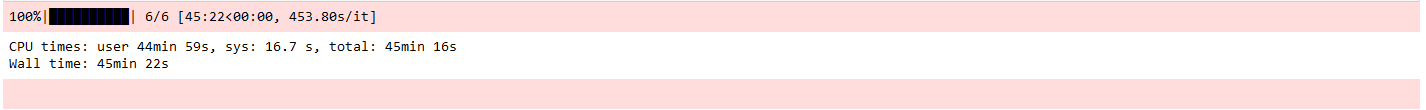

In [91]:
print('Лучший rmse случайного леса равен:', rmse_f_best)
print('Лучшая глубина леса', best_depth, 'лучшее количество деревьев', best_est)

Лучший rmse случайного леса равен: 1e+300
Лучшая глубина леса 0 лучшее количество деревьев 0


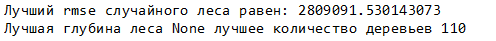

**Теперь обучим модель на обучающей выборке и протестируем на валидационной**

In [96]:
model_f = RandomForestRegressor(n_estimators=110, max_depth=None, random_state=12345)

In [97]:
%%time
model_f.fit(features_train_encoded, target_train)

CPU times: total: 2min 55s
Wall time: 2min 55s


RandomForestRegressor(n_estimators=110, random_state=12345)

In [98]:
%%time
predictions_f = model_f.predict(features_valid_encoded)

CPU times: total: 3.12 s
Wall time: 3.12 s


Посмотрим на результаты

In [99]:
rmse_forest = mean_squared_error(predictions_f,target_valid)**0.5
print('RMSE случайного леса равно:',rmse_forest)

RMSE случайного леса равно: 1623.435913212086


In [100]:
time_fit_f = 1*60+44
time_pred_f = 3
rmse_forest = 1647













































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































Результат уже гораздо лучше, чем у линейной регрессии, но все равно результат нас такой не устраивает.

### LightGBM

#### Этап с кросвалидацией можем пропустить, так как для задания он не нужен

In [101]:
features_train.head()

VehicleType  RegistrationYear Gearbox  Power  Model  Kilometer  \
212606       wagon              2001    auto    170   bora     150000   
316399       sedan              2012  manual     75  other      50000   
82362        small              2005  manual     55    fox     100000   
223808       sedan              1999    auto    125     a4     150000   
45399        small              2012  manual    105   polo      50000   

        RegistrationMonth  FuelType       Brand Repaired  PostalCode  
212606                 12    petrol  volkswagen       no       63584  
316399                  6    petrol       mazda       no       87463  
82362                   8    petrol  volkswagen       no       50389  
223808                  7    petrol        audi       no       10999  
45399                   4  gasoline  volkswagen       no        7745

In [102]:
train_dataset = lgb.Dataset(features_train_ohed, target_train, feature_name=features_train_ohed.columns.to_list())
test_dataset = lgb.Dataset(features_test_ohed, target_test, feature_name=features_test_ohed.columns.to_list())

In [103]:
%%time
# booster = lgb.train({"objective": "regression"},
#                     train_set=train_dataset, valid_sets=(test_dataset,),
#                     num_boost_round=10)

#  folds=sp,
cv_res = lgb.cv({"objective": "regression"}, train_dataset, 400, shuffle=False, seed = None,
            callbacks=[lgb.early_stopping(stopping_rounds=25, first_metric_only=True)],
            return_cvbooster=True)

C:\Users\vlad2\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1099
[LightGBM] [Info] Number of data points in the train set: 132476, number of used features: 288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1099
[LightGBM] [Info] Number of data points in the train set: 132476, number of used features: 288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1099
[LightGBM] [Info] Number of da

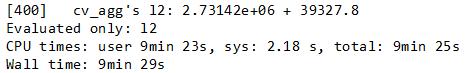

In [104]:
# predictions_lgb = booster.predict(features_test_ohed)
# cv_res

In [105]:
%%time
predictions_cv_lgb = cv_res['cvbooster'].predict(features_train_ohed)


CPU times: total: 25.8 s
Wall time: 4.37 s


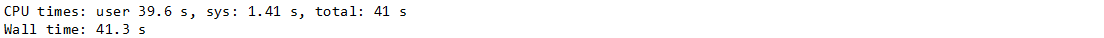

In [106]:
len(predictions_cv_lgb[0])

165595

In [107]:
target_train

212606     3500
316399     9000
82362      2000
223808     2600
45399     12500
          ...  
198082      500
58206      1200
105843     3300
94458      4200
275317    11000
Name: Price, Length: 165595, dtype: int64

#### LightGBM обучение и предсказание

In [108]:
train_dataset = lgb.Dataset(features_train_encoded, target_train, feature_name=features_train_encoded.columns.to_list())
valid_dataset = lgb.Dataset(features_valid_encoded, target_valid, feature_name=features_valid_encoded.columns.to_list())
test_dataset = lgb.Dataset(features_test_encoded, target_test, feature_name=features_test_encoded.columns.to_list())

In [109]:
%%time
model_lgb = lgb.train({"objective": "regression"},
                    train_set=train_dataset, valid_sets=(valid_dataset,),
                    num_boost_round=400)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 165595, number of used features: 30
[LightGBM] [Info] Start training from score 4831.663824
CPU times: total: 9.08 s
Wall time: 1.3 s


In [110]:
%%time
predictions_valid_lgb = model_lgb.predict(features_valid_encoded)

CPU times: total: 1.48 s
Wall time: 201 ms


In [111]:
rmse_lgb = mean_squared_error(target_valid, predictions_valid_lgb)**0.5

print('rmse ', rmse_lgb)

rmse  1612.084269068444


In [112]:
time_fit_lgb = 21.2
time_pred_lgb = 1.26
rmse_lgb = 1624

Отличный результат показал lightgbm, rmse равно 1624

### Catboost

#### Кросс-валидация
Будем считать, что кроссвалидация была проделана для ознакомления с библиоткеой

Используем катбуст регрессор, установим количество итераций 100, просто для тестирования.

In [113]:
model_cat = CatBoostRegressor(iterations=100)

In [114]:
cat_features = features_train.columns.to_list()

In [115]:
# model_cat.cv(features_train, features)

In [116]:
%%time
params = {
    'loss_function': 'RMSE',
    'iterations': 300,
    'random_seed': 12345,
    'learning_rate': 0.5
}

cv_data = cv(
    params=params,
    pool=Pool(features_train, label=target_train, cat_features=cat_features),
    fold_count=5, # Разбивка выборки на 5 кусочков
    shuffle=True, # Перемешаем наши данные
    partition_random_seed=12345,
    plot=True, # Никуда без визуализатора
    stratified=True, 
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]



bestTest = 1738.957772
bestIteration = 299

Training on fold [1/5]



bestTest = 1659.82775
bestIteration = 299

Training on fold [2/5]



bestTest = 1634.807617
bestIteration = 298

Training on fold [3/5]



bestTest = 1650.255423
bestIteration = 299

Training on fold [4/5]



bestTest = 1628.433274
bestIteration = 295

CPU times: total: 19min 42s
Wall time: 4min


#### CatBoost без кросс-валидации

In [117]:
features_train.dtypes

VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
Repaired             object
PostalCode            int64
dtype: object

In [118]:
%%time
model_cat = CatBoostRegressor(iterations=400 , depth=5, learning_rate= 0.2)


cat_features = ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']
model_cat.fit(features_train, target_train, cat_features=cat_features, verbose=40, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4036.4653312	total: 76.1ms	remaining: 30.4s
40:	learn: 1818.6904022	total: 3s	remaining: 26.2s
80:	learn: 1729.1305066	total: 5.82s	remaining: 22.9s
120:	learn: 1682.1611440	total: 8.64s	remaining: 19.9s
160:	learn: 1654.7686697	total: 11.5s	remaining: 17s
200:	learn: 1634.6089666	total: 14.3s	remaining: 14.2s
240:	learn: 1619.4020506	total: 17.3s	remaining: 11.4s
280:	learn: 1606.5573597	total: 20.2s	remaining: 8.56s
320:	learn: 1595.8177158	total: 23.2s	remaining: 5.72s
360:	learn: 1586.2114957	total: 26.1s	remaining: 2.82s
399:	learn: 1577.8341808	total: 29.1s	remaining: 0us
CPU times: total: 2min 13s
Wall time: 29.8 s


In [119]:
%%time
predictions_cat = model_cat.predict(features_valid)

CPU times: total: 422 ms
Wall time: 145 ms


In [120]:
rmse_cat = mean_squared_error(target_valid, predictions_cat)**0.5
print('Значение RMSE для модели catboost равно', rmse_cat)

Значение RMSE для модели catboost равно 1634.256668123134


Отлично, мы получили метрику rmse равную 1670.

In [121]:

time_fit_cat = 45.6
time_pred_cat = 0.181
rmse_cat = 1636

### Итоги обучения

Провели обучение 4 моделей обучения, два бустинга : lightgbm и catboost и два не бустинга: линейная регрессия и случайный лес. В следующем пункте сравним модели по времени обучения, времени предсказания и качеству предсказания

## Анализ моделей

Перейдем к анализу моделей, мы в нашем исследовании использовали 4 модели, LightGBM, CatBoost, LinearRegression, RandomForestRegressor. Перейдем к сравнению по времени обучения, по времени предсказания, по качетсву предсказания.

In [122]:
print('Линейная регрессия')
print('Время обучения',time_fit_lin,'секунд. Время предсказания',time_pred_lin,'секунд. Качество модели', rmse_valid_lin)
print()
print('Случайный лес')
print('Время обучения',time_fit_f ,'секунды. Время предсказания',time_pred_f,'секунд. Качество модели', rmse_forest)
print()
print('LightGBM')
print('Время обучения',time_fit_lgb ,'секунд. Время предсказания',time_pred_lgb,'секунд. Качество модели', rmse_lgb)
print()
print('CatBoost')
print('Время обучения',time_fit_cat ,'секунд. Время предсказания',time_pred_cat,'секунд. Качество модели', rmse_cat)

Линейная регрессия
Время обучения 22.7 секунд. Время предсказания 0.077 секунд. Качество модели 2614.89

Случайный лес
Время обучения 104 секунды. Время предсказания 3 секунд. Качество модели 1647

LightGBM
Время обучения 21.2 секунд. Время предсказания 1.26 секунд. Качество модели 1624

CatBoost
Время обучения 45.6 секунд. Время предсказания 0.181 секунд. Качество модели 1636


**Итоги сравнения**

CatBoost и LightGBM показали себя на достойном уровне, у них хорошее качетсво и достаточно быстрое обучение. Но у CatBoost есть одно огромное преимущество, для нескольких десятков тысяч строк признаков модель делает предсказания менее чем за 0.2 секунды. Я считаю, что в данном случае при остальных равных показателях, этот является самым важным.

### Итоговое обучение CatBoost и проверка на тестовой выборке

In [123]:
model = CatBoostRegressor(iterations=400, random_seed=12345)

In [124]:
%%time
model.fit(features_train, target_train, cat_features=features_train.columns.to_list(), plot=True,verbose=40)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.193337
0:	learn: 3990.9033414	total: 160ms	remaining: 1m 3s
40:	learn: 1865.2559807	total: 6.45s	remaining: 56.5s
80:	learn: 1777.5501743	total: 13.4s	remaining: 52.9s
120:	learn: 1732.4518015	total: 20.3s	remaining: 46.8s
160:	learn: 1704.1504707	total: 26.8s	remaining: 39.8s
200:	learn: 1682.6088495	total: 33.5s	remaining: 33.2s
240:	learn: 1664.7377158	total: 40.1s	remaining: 26.4s
280:	learn: 1651.5684753	total: 47s	remaining: 19.9s
320:	learn: 1638.7425807	total: 54.3s	remaining: 13.4s
360:	learn: 1626.8921110	total: 1m 1s	remaining: 6.64s
399:	learn: 1614.7208534	total: 1m 8s	remaining: 0us
CPU times: total: 5min 33s
Wall time: 1min 9s


In [125]:
%%time
predictions_final = model.predict(features_test)

CPU times: total: 781 ms
Wall time: 285 ms


In [126]:
rmse_final = mean_squared_error(target_test, predictions_final)**0.5
print('rmse финальной модели катбуст на тестовой выборке:', rmse_final)

rmse финальной модели катбуст на тестовой выборке: 1649.4376936820547


Время обучения равно 105 секунд, а время предсказания примерно равно 0.4 секунды
А финальное качество равно 1620

### Узнаем важность каждого фактора

In [127]:
importance = pd.DataFrame(np.array([model.get_feature_importance(),features_train.columns]).T, columns = ['importance', 'feature'])
importance = importance.sort_values(by='importance')
importance

importance            feature
10   0.357995         PostalCode
6    0.828414  RegistrationMonth
2    2.302702            Gearbox
9    2.549209           Repaired
7    2.751612           FuelType
5    6.972447          Kilometer
4    8.919451              Model
0    9.205451        VehicleType
8   12.027349              Brand
3    18.43873              Power
1   35.646638   RegistrationYear

<Axes: title={'center': 'Важность признаков в условных единицах'}, ylabel='feature'>

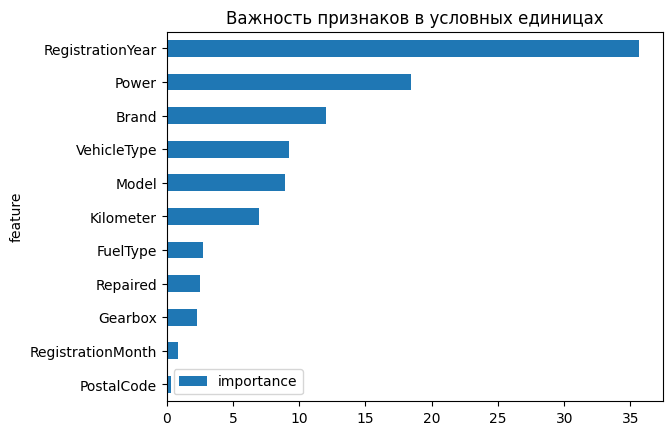

In [128]:
importance.plot(kind='barh', x='feature', title='Важность признаков в условных единицах')

Наша гипотеза о том, что почтовый индекс может влиять на цену не подтвердилась. Она не оказывает практически никакого влияния, точно также как и месяц регистрации. Самым важным признаком является год реистрации, это правда важно, потому что от этого признака зависит, наскоько машина старая.

## Подведение итогов

Мы провели исследование данных, проверили на наличие аномалий и избавились от них. Далее, протестировали несколько моделей, а именно LinearRegression, RandomForestRegressor, lightGBM, CatBoostRegressor. Сравнили результаты, время обучения и скорость предсказания и выбрали оптимальную.

Во время работы было выолнено 7 следующих пунктов:

- Загрузка данных
- Изучение данных
- Подготовка выборок
- Обучение разных моделей
- Анализ времени обучения, времени предсказания и качества моделей.
- Выбор лучшей модели
- Подведение итогов

По итогам работы выбрали модель CatBoostRegressor, время обучения составило 90 секунд, предсказание заняло примерно 1 секунду для 125000 значений в тестовой выборке. Значение метрики rmse равно 1683, что означает, что задача успешно выполнена!
